In [1]:
from DiabetesModels import *

# Parameters for simulation
environment = read_env(ndim=3)

# Setup simulation from env dict
simulation = Simulation(environment._asdict())
# Get idea of paars to change
environment

# Turn notebook into script
# !jupyter nbconvert --to script config_template.ipynb

env(path='debug/', maxPatient=1000, patientNr=0, path_to_simulations='simulations/', nMeals=200, ndim=3, loss_fun='CGP', jupyter=True, hypoglycemia=5, target=5, patient_filter=True)

In [2]:
if simulation.jupyter:
    !jupyter nbconvert --to script run_bayesian_3d.ipynb
    !mv run_bayesian_3d.py simulations/

[NbConvertApp] Converting notebook run_bayesian_3d.ipynb to script
[NbConvertApp] Writing 6303 bytes to run_bayesian_3d.py


In [3]:
#### 
# q=0 713
# q=0.025 660
# q=0.25 622
# q=0.5 797
# q=0.75 14
# q=0.975 535
# q=1 346

In [4]:
# Change parameters of simulation here if you want to
# look above!
# simulation.par = xxx
if simulation.jupyter:
    simulation.patientNr = 346

simulation.loss_fun = 'CGP'
simulation.nMeals = 200 
simulation.patient_filter = True
simulation.hypoglycemia = 5.0
simulation.target = 5.0
#simulation.hypoglycemia = 4.2
## Initiate simulation for patient

# print environment for debugging purposes
simulation_tuple = namedtuple('debug_tuple', simulation.__dict__)
print(simulation_tuple(**simulation.__dict__))

debug_tuple(path='debug/', maxPatient=1000, patientNr=346, path_to_simulations='simulations/', nMeals=200, ndim=3, loss_fun='CGP', jupyter=True, hypoglycemia=5.0, target=5.0, patient_filter=True)


In [5]:
### Init patient
simulation.init_patient()

Basal rate found to be 14.521666577544085 [mU/min] for patientNr 346


Crude ICR estimated to be 0.005865285553198764


In [6]:
# Crude estimates
c_lower = 1/0.05639379343662062
c_upper = 1/0.005145130333656435

In [7]:
from scipy import interpolate

# Forget about this junk

var_interp = interpolate.interp1d(np.array([c_lower, c_upper]), np.array([150,300]))
#scaling_constant_interp = interpolate.interp1d(np.array([c_lower, c_upper]), np.array([np.sqrt(0.01),np.sqrt(0.005)]))# <-- No longer needed
lscale_interp = interpolate.interp1d(np.array([c_lower**2, c_upper**2]), np.array([50,3000]))

m = 1/simulation.patient.ICR


In [8]:
var0 = 100
lscale = 150
# simulation.patient.scale_constant = scaling_constant_interp(m)

simulation.patient.scale_constant =  5.0#simulation.patient.ISF

In [9]:
#lscale = lscale_interp(m**2)
#var0 = var_interp(m)
var0 = 100
lscale = 150
#var0 = 500
# simulation.patient.scale_constant = scaling_constant_interp(m)
simulation.patient.scale_constant =  5.0#simulation.patient.ISF

In [10]:
### Cell used for Bolus method

import GPy
import bayesoptlib as BO

#lscale go from 500 to 1500 
kernel =  GPy.kern.Matern52(simulation.ndim,ARD=True,lengthscale=[lscale,5,5],variance=var0) #+ GPy.kern.Bias(simulation.ndim) #+ GPy.kern.Linear(simulation.ndim, ARD=True)

kernel.lengthscale.constrain_bounded(1e-3,500)
kernel.variance.constrain_fixed()

mf = GPy.core.Mapping(simulation.ndim,1)
mf.f = simulation.patient.prior_3d_experiment
mf.update_gradients = lambda a,b: None

bolus_range = np.linspace(0, max(simulation.patient.u_opt).squeeze() + 1000, 5000)
meal_range = np.linspace(0, 20, 1000)


bolus_bounds = np.array([min(bolus_range), max(bolus_range)])

### Make function that takes in Meal and returns bolus - this case Bayesian Optimization
def bolus_fun(Meal, simulation):


    ### Run doctor's formula to update ICR at each session

    patient = simulation.patient

    context = np.array([Meal.item(),simulation.xinit[10]]).reshape(-1,2)

    m = GPy.models.GPRegression(simulation.X_sample,simulation.Y_sample,mean_function = mf, kernel = kernel, noise_var=0)

    CBO = BO.contextual_bayesian_optimization(simulation.X_sample,simulation.Y_sample,context,bolus_bounds,mf,
                                    kernel, m, X_grid = bolus_range)

    CBO.m.Gaussian_noise.variance.constrain_fixed()

    if len(simulation.X_sample) > 20:
        CBO.m.optimize()
        #CBO.m.optimize_restarts(num_restarts = 10, verbose=0)

    CBO.query_next_UCB()
    Bolus = CBO.X_next[0][0]

    # have step for saving 
    save_pred = False
    if save_pred and simulation.jupyter:
        try:
            patient.bayes_opt_posterior
        except: # First iteration
            patient.bayes_opt_prior = []
            patient.bayes_opt_posterior = []
            patient.acq_fun = []
            patient.true_fun = []
    
        patient.bayes_opt_prior.append(CBO.prior())

        # posterior
        mu, sigma = CBO.posterior()
        
        patient.bayes_opt_posterior.append(mu)

        patient.acq_fun.append(mu - 2 * sigma)

        # Simulate 40 meals to be used for obtaining true fun
        n_int = simulation.nMeals
        BOLUS_RANGE = np.linspace(min(bolus_range),max(bolus_range),n_int)
        true_fun_i = np.empty((n_int))
        for i, b in enumerate(BOLUS_RANGE):
            CGM = patient.simulate(Bolus=b, Meal=Meal, x0 = simulation.xinit, set_end_points=False)
            GP = 1/2*(CGM - patient.target)**2 + 1/2*100*np.maximum(patient.hypoglycemia - patient.CGM, 0)**2
            true_fun_i[i] = GP.sum()
        
        patient.true_fun.append(true_fun_i)

    simulation.CBO = CBO
    return Bolus

reconstraining parameters Mat52.lengthscale


In [11]:
### Do simulation
simulation.simulate(simulation.simulate_meals, bolus_fun = bolus_fun)

Simulating for PatientNr: 346:   8%|▊         | 16/200 [00:02<00:27,  6.68it/s]


KeyboardInterrupt: 

No handles with labels found to put in legend.


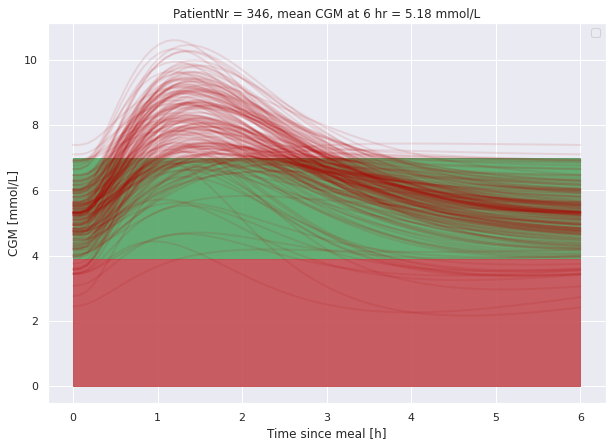

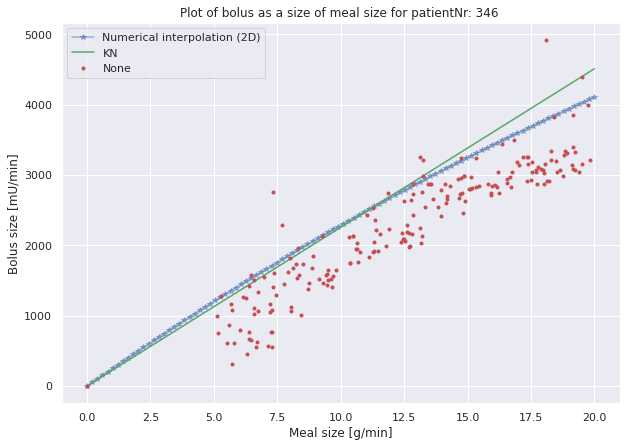

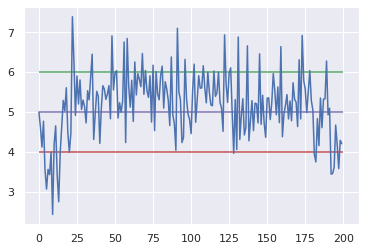

5.174846132768518 96.48611111111111 3.2152777777777777


In [12]:
if simulation.jupyter:
    simulation.patient.set_u_opt()
    simulation.plot_CGM()
    simulation.make_u_opt_plot()

    plt.figure()
    plt.plot(simulation.nBG0)
    plt.hlines(6,0,200,'g')
    plt.hlines(5,0,200,'m')
    plt.hlines(4,0,200,'r')
    plt.show()

    print(simulation.nBG0.mean(),simulation.nTIR.mean(), simulation.nTBR.mean())

    

In [13]:
def plot_process_i(i):
    patient = simulation.patient
    posterior = patient.bayes_opt_posterior[i]
    prior = patient.bayes_opt_prior[i]
    true_fun = patient.true_fun[i]
    acq_fun = patient.acq_fun[i]

    plt.figure(figsize=(10,7))
    plt.title(f'Plot for patient {simulation.patient.patientNr} iteration {i} with meal = {simulation.nMeal[i]:.2f} g/min and starting CGM= {simulation.X_sample[i+1,2]:.2f}')
    plt.plot(bolus_range, posterior, '-*', label = 'posterior')
    plt.plot(bolus_range, prior, '-', label = 'prior')
    plt.plot(bolus_range, acq_fun, '-', label = 'LCB - acq fun')
    x_true_fun = np.linspace(0, max(bolus_range), simulation.nMeals)
    plt.plot(x_true_fun, true_fun, '-*', label = 'true_fun')
    plt.xlabel('Bolus [mU/min]')

    print((posterior - prior).sum())
    print((posterior - acq_fun).sum())



    #plt.ylim(-1000,1000)
    #plt.xlim(0,800)
    plt.ylim(-2000,5000)
    plt.legend()
    plt.show()


In [14]:
if simulation.jupyter:
    simulation.CBO.kernel.lengthscale
    plot_process_i(15)

AttributeError: 'Patient' object has no attribute 'bayes_opt_posterior'